# Target Variable: `cnt`
##### For bussiness question and final conclusion, Go to bottom of page

In [62]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

bike_demand_data = pd.read_csv('./day.csv')

FileNotFoundError: [Errno 2] No such file or directory: './day.csv'

### Data Stats

In [63]:
bike_demand_data.describe().T

,count,mean,std,min,25%,50%,75%,max
yr,730.0,0.500000,0.500343,0.000000,0.000000,0.500000,1.000000,1.000000
holiday,730.0,0.028767,0.167266,0.000000,0.000000,0.000000,0.000000,1.000000
workingday,730.0,0.683562,0.465405,0.000000,0.000000,1.000000,1.000000,1.000000
temp,730.0,20.319259,7.506729,2.424346,13.811885,20.465826,26.880615,35.328347
hum,730.0,62.765175,14.237589,0.000000,52.000000,62.625000,72.989575,97.250000
windspeed,730.0,12.763620,5.195841,1.500244,9.041650,12.125325,15.625589,34.000021
cnt,730.0,4508.006849,1936.011647,22.000000,3169.750000,4548.500000,5966.000000,8714.000000


### Data Cleaning

In [64]:
"""Duplicate Check"""
bike_demand_data.drop_duplicates(inplace=True)
bike_demand_data.shape

(730, 11)

In [65]:
"""Null Check"""
bike_demand_data.info() # No Null Found

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    object 
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    object 
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    object 
 7   temp        730 non-null    float64
 8   hum         730 non-null    float64
 9   windspeed   730 non-null    float64
 10  cnt         730 non-null    int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 62.9+ KB



#### Exploratory Data Analysis


KeyError: "['casual'] not in index"

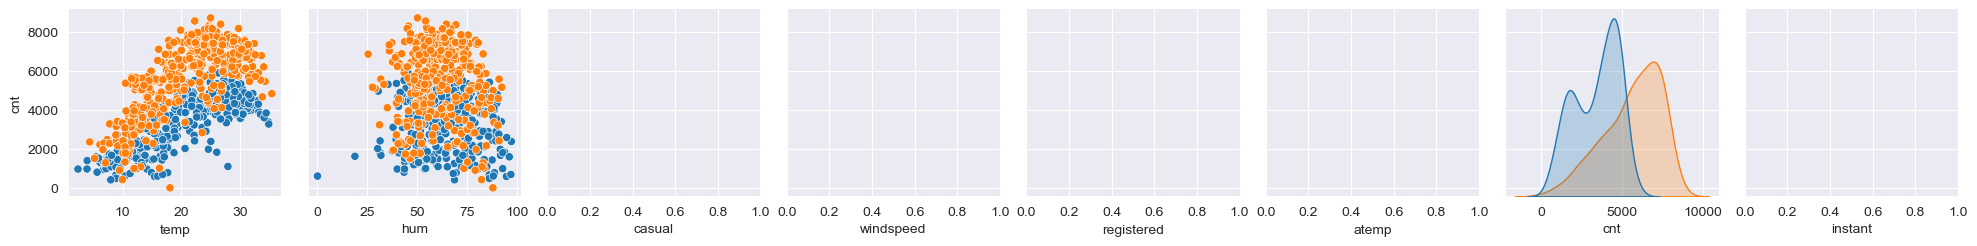

In [66]:
sns.pairplot(bike_demand_data, x_vars=["temp", "hum",'casual','windspeed','registered','atemp','cnt','instant'], y_vars=['cnt'], hue='yr')
plt.show()

In [ ]:
plt.figure(figsize=(20, 12))

for i,col in enumerate(['mnth','season', 'weekday', 'holiday', 'weathersit', 'yr', 'workingday']):
    plt.subplot(2, 4, i+1)
    sns.boxplot(x=col, y='cnt', data=bike_demand_data)
    plt.xticks(rotation=90)
    
plt.show()

In [ ]:
def plot_cat_col(df, column):
    plt.figure(figsize = (7,3))
    plt.subplot(1,2,1)
    sns.barplot(x=column,y='cnt',data=df, palette = "Set2")
    
    plt.subplot(1,2,2)
    sns.barplot(x=column,y='cnt',data=df, hue='yr',hue_order=[0,1],palette='Set2')
    L=plt.legend()
    L.get_texts()[0].set_text('2018')
    L.get_texts()[1].set_text('2019')
    plt.show()

In [ ]:
plot_cat_col(bike_demand_data, 'season')
plot_cat_col(bike_demand_data, 'weathersit')
plot_cat_col(bike_demand_data, 'holiday')
plot_cat_col(bike_demand_data, 'workingday')
plot_cat_col(bike_demand_data, 'yr')
plot_cat_col(bike_demand_data, 'mnth')
plot_cat_col(bike_demand_data, 'weekday')

In [ ]:
plt.figure(figsize = (6,6))
sns.heatmap(bike_demand_data[['cnt','temp','atemp','hum','windspeed']].corr(), annot=True, cmap='YlGnBu')
plt.show()

#### Based on EDA, below are the observations

- The fall season appears to have attracted more bookings. The number of bookings has notably risen for each season in 2019 compared to 2018.
- Clear weather has led to more bookings, which is expected. Additionally, bookings increased in 2019 for all weather conditions compared to 2018.
- On non-holiday days, bookings tend to be lower, which makes sense as people might prefer to stay home and spend time with family during holidays.
- The number of bookings was nearly the same on both working days and non-working days. However, the count increased from 2018 to 2019.
- There were more bookings in 2019 compared to the previous year, as shown in earlier plots.
- Most bookings occurred in May, June, July, August, September, and October. The trend increased from the start of the year until mid-year, then started to decline towards the end of the year. Each month’s bookings increased from 2018 to 2019.
- Wednesdays, Thursdays, Fridays, and Saturdays saw more bookings compared to other days (Sundays, Mondays, and Tuesdays) in 2019.
- The distinction between registered and casual users can only be made after a bike rental occurs, making both features functionally equivalent to the target variable. Consequently, these two features are redundant and can be removed.
- Registered Bike users are more than Casual and is strongly correlated with Target Variable
- Temp and atemp are very strongly correlated one can be dropped
- Humidity has not much Negative effect on the Target Variable.
- 'temp' and 'atemp' are both 63% correlated with the target variable 'cnt'
'temp' and 'atemp' are 99% correlated with each other. Both of the parameters cannot be used in the model due to multicolinearity issue. We will decide later which parameters to keep based on VIF and p-value w.r.t other variables.

### Data Preperation

In [67]:
"""
As per data dictionary atemp, casual, registered are highly correlated with cnt
instant is a serial_no col like
dteday can already being translated by other cols
"""

bike_demand_data = (
    bike_demand_data
    .drop(['atemp', 'casual', 'registered'], axis=1) # based on above graph, these cols are not related visually
    .drop(['instant', 'dteday'], axis=1) # unnecessary
)
bike_demand_data.head(5)

KeyError: "['atemp', 'casual', 'registered'] not found in axis"

In [ ]:
"""
Map categorical cols
"""

mappings =  {
    'season': {1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'},
    'mnth': { 1:'Jan',2:'Feb',3:'March',4:'April',5:'May', 6:'June',7:'July',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'},
    'weekday': {0:'Sunday', 1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thrusday', 5:'Friday',6:'Saturday'},
    'weathersit': {1:'Clear' ,2: 'Mist' , 3: 'Light'}
}

for col, rename_dict in mappings.items():
    bike_demand_data[col] = bike_demand_data[col].map(rename_dict)
    
bike_demand_data.head()

In [ ]:
"""
One Hot Encoding for categorical cols

Loop through the mappings and create dummy variables
Concatenate all dummy DataFrames with the original DataFrame (excluding the original categorical columns)

Correlated col values that would be dropped from the dummy variables:
we know 'Sunday' is highly correlated with other week day .i.e if today is no sorted(['Monday', 'Tuesday', ... 'Saturday']), Then today is Sunday
similary, ['Jan', 'spring'], one is month, another is a season

"""
    
dummies_list = []

for col, rename_dict in mappings.items():
    dummies = pd.get_dummies(bike_demand_data[col], drop_first=True, dtype=int) # drop_first will rm the first category after sorting cat col
    dummies_list.append(dummies)
    
bike_demand_data_with_dummies = pd.concat([
    bike_demand_data.drop(columns=mappings.keys()),  # Drop the original categorical columns
    *dummies_list  # Unpack the list of dummy DataFrames
], axis=1)

bike_demand_data_with_dummies.head()

In [68]:
bike_demand_data_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yr          730 non-null    int64  
 1   holiday     730 non-null    int64  
 2   workingday  730 non-null    int64  
 3   temp        730 non-null    float64
 4   hum         730 non-null    float64
 5   windspeed   730 non-null    float64
 6   cnt         730 non-null    int64  
 7   spring      730 non-null    int64  
 8   summer      730 non-null    int64  
 9   winter      730 non-null    int64  
 10  Aug         730 non-null    int64  
 11  Dec         730 non-null    int64  
 12  Feb         730 non-null    int64  
 13  Jan         730 non-null    int64  
 14  July        730 non-null    int64  
 15  June        730 non-null    int64  
 16  March       730 non-null    int64  
 17  May         730 non-null    int64  
 18  Nov         730 non-null    int64  
 19  Oct         730 non-null    i

### Data Visualization

In [69]:
df = bike_demand_data_with_dummies.copy() #kept a copy to start again in case to start from scratch

In [70]:
styled_df = df.describe().T.style.background_gradient(cmap='cividis', axis=1).format('{:.2f}')
styled_df

,count,mean,std,min,25%,50%,75%,max
yr,730.00,0.50,0.50,0.00,0.00,0.50,1.00,1.00
holiday,730.00,0.03,0.17,0.00,0.00,0.00,0.00,1.00
workingday,730.00,0.68,0.47,0.00,0.00,1.00,1.00,1.00
temp,730.00,20.32,7.51,2.42,13.81,20.47,26.88,35.33
hum,730.00,62.77,14.24,0.00,52.00,62.62,72.99,97.25
windspeed,730.00,12.76,5.20,1.50,9.04,12.13,15.63,34.00
cnt,730.00,4508.01,1936.01,22.00,3169.75,4548.50,5966.00,8714.00
spring,730.00,0.25,0.43,0.00,0.00,0.00,0.00,1.00
summer,730.00,0.25,0.43,0.00,0.00,0.00,1.00,1.00
winter,730.00,0.24,0.43,0.00,0.00,0.00,0.00,1.00


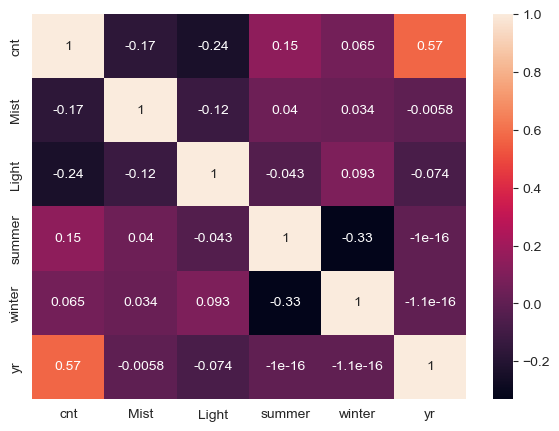

In [71]:
plt.figure(figsize = (7,5))
sns.heatmap(df[['cnt', 'Mist','Light','summer','winter','yr']].corr(),annot =True)
plt.show()

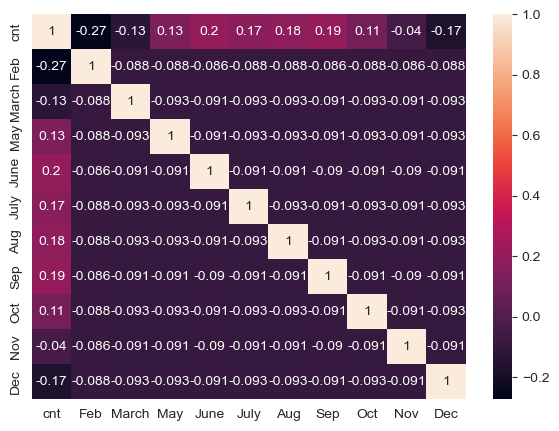

In [72]:
plt.figure(figsize = (7,5))
sns.heatmap(df[['cnt','Feb','March','May','June','July' ,'Aug','Sep','Oct','Nov','Dec']].corr(),annot = True)
plt.show()

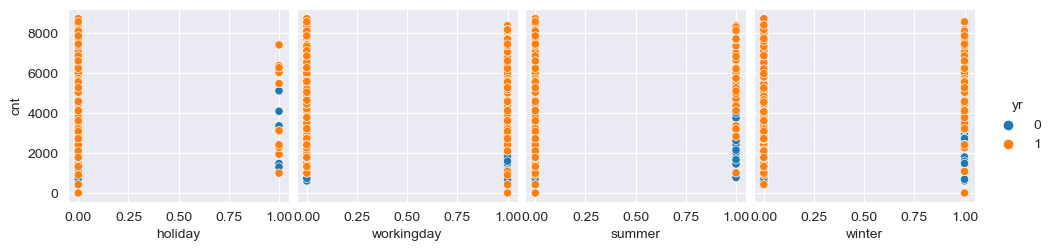

In [73]:
sns.pairplot(df,x_vars =['holiday', 'workingday','summer','winter'],y_vars='cnt',hue ='yr')
plt.show()

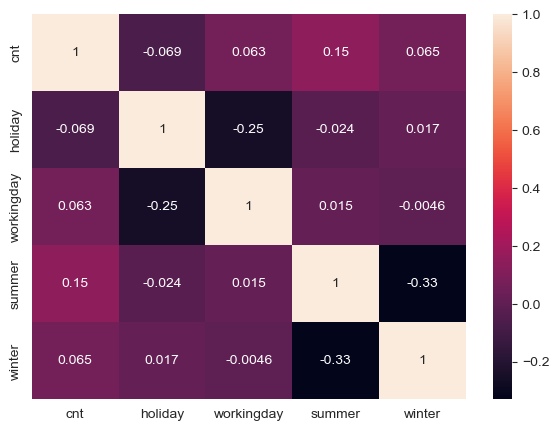

In [74]:
plt.figure(figsize = (7,5))
sns.heatmap(df[['cnt','holiday', 'workingday','summer','winter']].corr(),annot = True)
plt.show()

#### Spliting Data

In [75]:
df = bike_demand_data_with_dummies.copy() #kept a copy to start again in case to start from scratch
df.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,spring,summer,winter,...,Oct,Sep,Monday,Saturday,Sunday,Thrusday,Tuesday,Wednesday,Light,Mist
0,0,0,0,14.110847,80.5833,10.749882,985,1,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0,0,0,14.902598,69.6087,16.652113,801,1,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0,0,1,8.050924,43.7273,16.636703,1349,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,8.200000,59.0435,10.739832,1562,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,1,9.305237,43.6957,12.522300,1600,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [76]:
from sklearn.model_selection import train_test_split
df_train,df_test = train_test_split(df,train_size=0.7,random_state=1998)

In [77]:
df_train.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,spring,summer,winter,...,Oct,Sep,Monday,Saturday,Sunday,Thrusday,Tuesday,Wednesday,Light,Mist
702,1,0,1,19.509153,73.3750,11.666643,6606,0,0,1,...,0,0,0,0,0,0,1,0,0,0
252,0,0,0,27.060000,75.3750,10.291736,5345,0,0,0,...,0,1,0,1,0,0,0,0,0,0
342,0,0,1,11.924153,69.5833,5.542019,3620,0,0,1,...,0,0,0,0,0,0,0,0,0,0
261,0,0,1,22.515847,69.0000,10.166714,4539,0,0,0,...,0,1,1,0,0,0,0,0,0,1
506,1,0,1,25.215000,76.5833,7.917189,6073,0,1,0,...,0,0,0,0,0,0,1,0,0,1


#### Scaling

In [78]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

cols_to_be_scaled = ['cnt', 'hum', 'windspeed', 'temp']
df_train[cols_to_be_scaled] = scaler.fit_transform(df_train[cols_to_be_scaled])

In [79]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
yr,510.0,0.509804,0.500395,0.0,0.000000,1.000000,1.000000,1.0
holiday,510.0,0.031373,0.174494,0.0,0.000000,0.000000,0.000000,1.0
workingday,510.0,0.676471,0.468282,0.0,0.000000,1.000000,1.000000,1.0
temp,510.0,0.536701,0.246911,0.0,0.321762,0.558514,0.753700,1.0
hum,510.0,0.642208,0.150984,0.0,0.525278,0.640150,0.750214,1.0
windspeed,510.0,0.318673,0.165496,0.0,0.197838,0.302130,0.410486,1.0
cnt,510.0,0.497990,0.234109,0.0,0.335610,0.503324,0.677082,1.0
spring,510.0,0.250980,0.434003,0.0,0.000000,0.000000,0.750000,1.0
summer,510.0,0.256863,0.437332,0.0,0.000000,0.000000,1.000000,1.0
winter,510.0,0.229412,0.420867,0.0,0.000000,0.000000,0.000000,1.0


#### Spliting Feature Col & Target Variable

In [80]:
X_train, y_train = df_train, df_train.pop('cnt')

## Model
#### For a Good Model, R2 should more, p values in range 0.05, IVF in range of 2

For iterative approach for finding a good model,

4 scenarios based on p-values and VIF information:

1. **High p-value, high VIF** - Remove them (as the variable is less significant and highly collinear with others).
2. **High p-value, low VIF** - Remove these before removing 3rd scenario variables.
3. **Low p-value, high VIF** - Remove these after removing 2nd scenario variables.
4. **Low p-value, low VIF** - Keep them as it is (high significance + less collinear).



In [81]:
"""Feature Selection: automatically using RFE"""

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(estimator=lm, n_features_to_select=15, step=1)
rfe = rfe.fit(X_train, y_train)

In [82]:
col_rfe_selected = X_train.columns[rfe.support_]
print(f"Automated Selected Cols: \n{list(col_rfe_selected)}")
print(f"\nRejected Cols: \n{list(X_train.columns[~rfe.support_])}")

Automated Selected Cols: 
['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'spring', 'winter', 'Dec', 'July', 'Nov', 'Saturday', 'Sunday', 'Light', 'Mist']

Rejected Cols: 
['summer', 'Aug', 'Feb', 'Jan', 'June', 'March', 'May', 'Oct', 'Sep', 'Monday', 'Thrusday', 'Tuesday', 'Wednesday']


In [83]:
"""Feature Selection: Manual after generating 15 cols automatically using RFE"""

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def get_variance_inflation_factor(df):
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

In [84]:
"""
Iteration: Model 0
"""
X_train_rfe = X_train[col_rfe_selected]
X_train_sm = sm.add_constant(X_train_rfe)

lr_model = sm.OLS(y_train,X_train_sm).fit()

print(lr_model.summary())
print(get_variance_inflation_factor(X_train_rfe))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     234.4
Date:                Thu, 01 Aug 2024   Prob (F-statistic):          5.74e-208
Time:                        09:46:18   Log-Likelihood:                 535.51
No. Observations:                 510   AIC:                            -1041.
Df Residuals:                     495   BIC:                            -977.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2486      0.024     10.498      0.0

In [85]:
"""
Iteration: Model 1
"""

X_train_rfe = X_train_rfe.drop('holiday',axis=1)
X_train_sm = sm.add_constant(X_train_rfe)
lr_model = sm.OLS(y_train,X_train_sm).fit()
print(lr_model.summary())
print(get_variance_inflation_factor(X_train_rfe))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     234.4
Date:                Thu, 01 Aug 2024   Prob (F-statistic):          5.74e-208
Time:                        09:46:19   Log-Likelihood:                 535.51
No. Observations:                 510   AIC:                            -1041.
Df Residuals:                     495   BIC:                            -977.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2609      0.036      7.226      0.0

In [86]:
"""
Iteration: Model 2
"""

X_train_rfe = X_train_rfe.drop('Sunday',axis=1)
X_train_sm = sm.add_constant(X_train_rfe)
lr_model = sm.OLS(y_train,X_train_sm).fit()
print(lr_model.summary())
print(get_variance_inflation_factor(X_train_rfe))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     251.6
Date:                Thu, 01 Aug 2024   Prob (F-statistic):          1.14e-208
Time:                        09:46:19   Log-Likelihood:                 534.30
No. Observations:                 510   AIC:                            -1041.
Df Residuals:                     496   BIC:                            -981.3
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2911      0.030      9.613      0.0

In [87]:
"""
Iteration: Model 3
"""

X_train_rfe = X_train_rfe.drop('hum',axis=1)
X_train_sm = sm.add_constant(X_train_rfe)
lr_model = sm.OLS(y_train,X_train_sm).fit()
print(lr_model.summary())
print(get_variance_inflation_factor(X_train_rfe))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     262.7
Date:                Thu, 01 Aug 2024   Prob (F-statistic):          2.81e-206
Time:                        09:46:20   Log-Likelihood:                 525.72
No. Observations:                 510   AIC:                            -1025.
Df Residuals:                     497   BIC:                            -970.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2082      0.023      9.055      0.0

In [88]:
"""
Iteration: Model 4
"""

X_train_rfe = X_train_rfe.drop('temp',axis=1)
X_train_sm = sm.add_constant(X_train_rfe)
lr_model = sm.OLS(y_train,X_train_sm).fit()
print(lr_model.summary())
print(get_variance_inflation_factor(X_train_rfe))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     175.1
Date:                Thu, 01 Aug 2024   Prob (F-statistic):          3.07e-163
Time:                        09:46:23   Log-Likelihood:                 420.93
No. Observations:                 510   AIC:                            -817.9
Df Residuals:                     498   BIC:                            -767.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5022      0.017     29.971      0.0

In [89]:
"""
Iteration: Model 5
"""

X_train_rfe = X_train_rfe.drop('July',axis=1)
X_train_sm = sm.add_constant(X_train_rfe)
lr_model = sm.OLS(y_train,X_train_sm).fit()
print(lr_model.summary())
print(get_variance_inflation_factor(X_train_rfe))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     192.7
Date:                Thu, 01 Aug 2024   Prob (F-statistic):          3.07e-164
Time:                        09:46:24   Log-Likelihood:                 420.57
No. Observations:                 510   AIC:                            -819.1
Df Residuals:                     499   BIC:                            -772.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5058      0.016     31.232      0.0

In [90]:
"""
Iteration: Model 6
"""

X_train_rfe = X_train_rfe.drop('windspeed',axis=1)
X_train_sm = sm.add_constant(X_train_rfe)
lr_model = sm.OLS(y_train,X_train_sm).fit()
print(lr_model.summary())
print(get_variance_inflation_factor(X_train_rfe))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     196.8
Date:                Thu, 01 Aug 2024   Prob (F-statistic):          4.38e-158
Time:                        09:46:25   Log-Likelihood:                 403.28
No. Observations:                 510   AIC:                            -786.6
Df Residuals:                     500   BIC:                            -744.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4506      0.014     32.942      0.0

In [91]:
lr_model.params

const         0.450599
yr            0.256876
workingday    0.056203
spring       -0.309874
winter        0.040586
Dec          -0.126752
Nov          -0.170033
Saturday      0.057638
Light        -0.264707
Mist         -0.089956
dtype: float64

### Residual Analysis

In [92]:
# Predictions on Training set
y_train_pred = lr_model.predict(X_train_sm)
y_train_pred.head()

702    0.677512
252    0.508237
342    0.420636
261    0.416847
506    0.673722
dtype: float64

In [93]:
# Error = y_train - y_train_pred
res =  y_train - y_train_pred
res.head()

702    0.067683
252    0.084535
342   -0.036374
261    0.078500
506    0.007047
dtype: float64

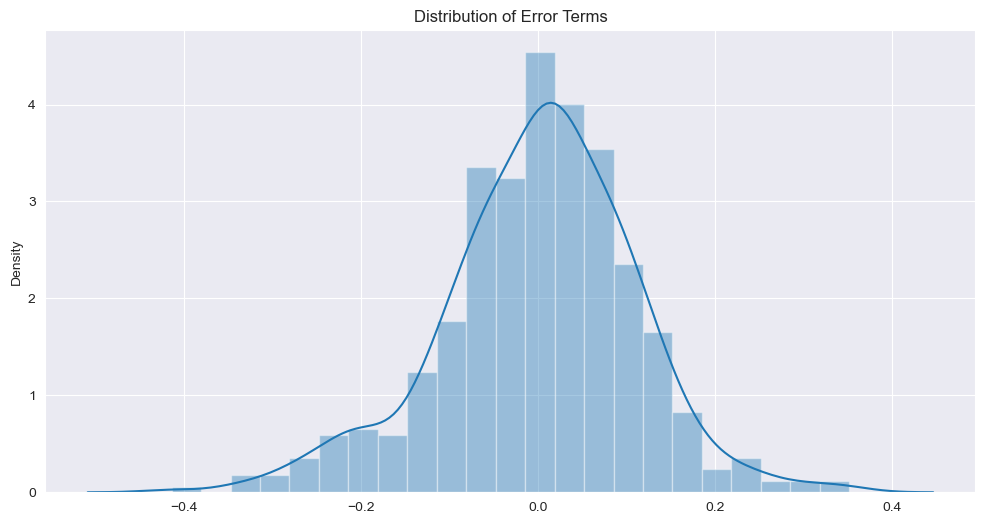

In [94]:
"""Residual Analysis: Normality"""
plt.figure(figsize = (12,6))
sns.set_style("darkgrid")
sns.distplot(res)
plt.title('Distribution of Error Terms')
plt.show()

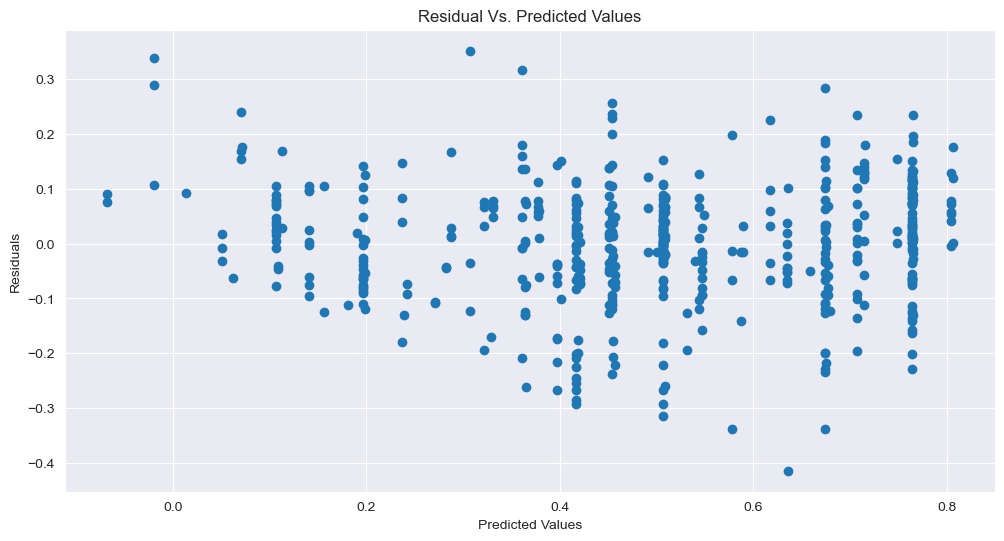

In [95]:
"""Residual Analysis: Homoscedasticity: Pattern"""
plt.figure(figsize = (12,6))
sns.set_style("darkgrid")
plt.scatter(y_train_pred,res)
plt.title('Residual Vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

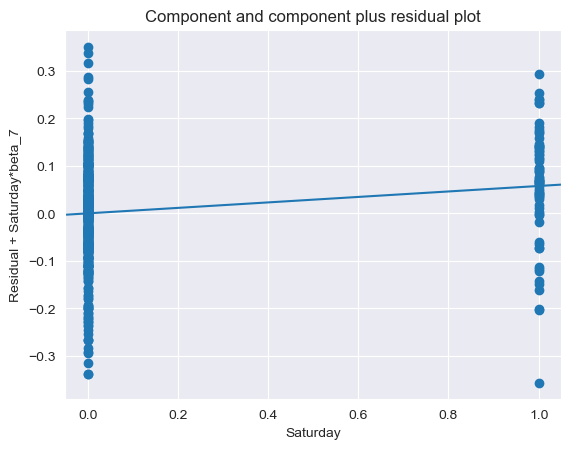

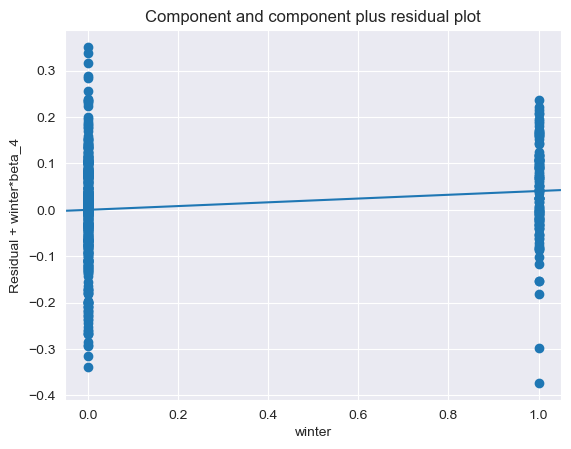

In [99]:
# Linear relationship validation using CCPR plot

sm.graphics.plot_ccpr(lr_model, 'Saturday')
sm.graphics.plot_ccpr(lr_model, 'winter')

plt.show()

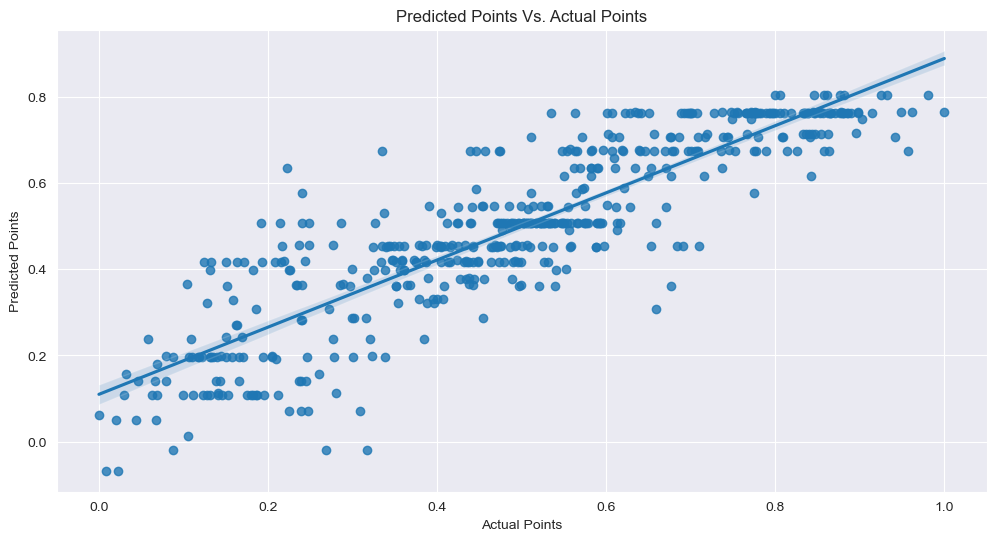

In [100]:
"""Residual Analysis: Constant Variance"""
plt.figure(figsize = (12,6))
sns.set_style("darkgrid")
sns.regplot(x=y_train, y=y_train_pred)
plt.title('Predicted Points Vs. Actual Points')
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.show()

### Prediction & Evaluation

In [101]:
df_test[cols_to_be_scaled] = scaler.transform(df_test[cols_to_be_scaled])

In [102]:
X_test, y_test = df_test, df_test.pop('cnt')

In [103]:
X_test = X_test[X_train_rfe.columns]

In [104]:
# Adding intercept
X_test_sm = sm.add_constant(X_test)

y_test_pred = lr_model.predict(X_test_sm)

### Model Evaluation

In [105]:
# R-Squared value on the test set
from sklearn.metrics import r2_score
r2_test = r2_score(y_true= y_test, y_pred=y_test_pred)
round(r2_test,3)

0.703

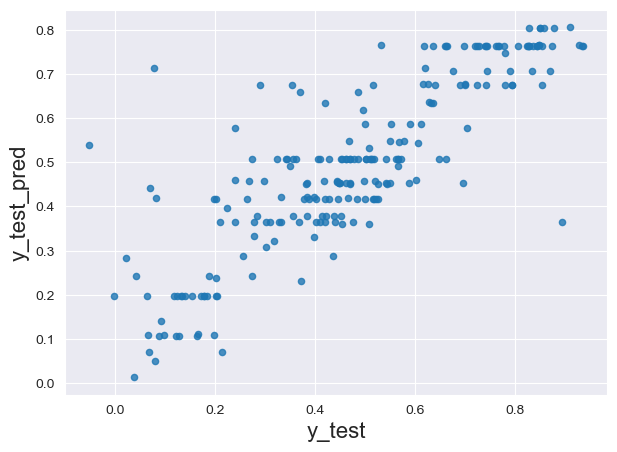

In [106]:
fig = plt.figure(figsize=(7,5))
plt.scatter(y_test, y_test_pred, alpha=0.8, s=20)
plt.xlabel('y_test', fontsize = 16)
plt.ylabel('y_test_pred', fontsize = 16) 
plt.show()

In [107]:
expression_vars = round(lr_model.params,4).sort_values(ascending = False)

In [109]:
for i in range(0, len(expression_vars)):
    print(expression_vars[i],'*',expression_vars.index[i],end ='')
    print(' + ',end ='')

0.4506 * const + 0.2569 * yr + 0.0576 * Saturday + 0.0562 * workingday + 0.0406 * winter + -0.09 * Mist + -0.1268 * Dec + -0.17 * Nov + -0.2647 * Light + -0.3099 * spring + 

In [ ]:
#End Of File

# Solution
$ \[ \text{demand(cnt)} = 0.4506 \times \text{const} + 0.2569 \times \text{yr} + 0.0576 \times \text{Saturday} + 0.0562 \times \text{workingday} + 0.0406 \times \text{winter} - 0.09 \times \text{Mist} - 0.1268 \times \text{Dec} - 0.17 \times \text{Nov} - 0.2647 \times \text{Light} - 0.3099 \times \text{spring} \] $

# Problem Statement
A bike-sharing system is a service in which bikes are made available for shared use to individuals on a short term basis for a price or free. Many bike share systems allow people to borrow a bike from a "dock" which is usually computer-controlled wherein the user enters the payment information, and the system unlocks it. This bike can then be returned to another dock belonging to the same system.

A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is finding it very difficult to sustain in the current market scenario. So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state.

In such an attempt, BoomBikes aspires to understand the demand for shared bikes among the people after this ongoing quarantine situation ends across the nation due to Covid-19. They have planned this to prepare themselves to cater to the people's needs once the situation gets better all around and stand out from other service providers and make huge profits.

They have contracted a consulting company to understand the factors on which the demand for these shared bikes depends. Specifically, they want to understand the factors affecting the demand for these shared bikes in the American market. The company wants to know:

1) Which variables are significant in predicting the demand for shared bikes
2) How well those variables describe the bike demands
Based on various meteorological surveys and people's styles, the service provider firm has gathered a large dataset on daily bike demands across the American market based on some factors.

Business Goal of the Assignment:
You are required to model the demand for shared bikes with the available independent variables. It will be used by the management to understand how exactly the demands vary with different features. They can accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations. Further, the model will be a good way for management to understand the demand dynamics of a new market.

The steps to be followed in this exercise are as follows:
Reading, understanding and visualizing the data

Preparing the data for model training (train-test split, rescaling)

Training the model

Residual analysis

Prediction and evaluation of the test set